In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from VariableInfoMap import defaultVarInfoMap

# USER from environment variable

In [2]:
USER = os.environ['USER']
print('USER:', USER)

USER: jskim


# Working directory

In [3]:
# Put the path of GUNDAMWorkshopSept2025 repo. Assuming you are at home directory
WD = f'/home/{USER}/GUNDAMWorkshopSept2025'
print('WD:', WD)

WD: /home/jskim/GUNDAMWorkshopSept2025


# CAF TruthTree

In [6]:
# 1) ICARUS NuMI 1muNp0pi
CAFFileBaseDir = '/exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/250627_BadRegionRejection/CAFTree'
CAFFileName = 'MakeTree_NuMI_MC_Nu_Phase2_2023ANuMIReproc_CAFTypeCommonRemerge_ReNuSyst250403_WithTrackSplit_BNBFixedProb.root'
CAFTreeName = 'AllSamples_FillTree/trueEvents'
CAFFluxWeightName = 'FluxWeightWithBeamWidthCorrection'
CAFSignalSelectionExpr = ''

CAFPOTHistName = 'AllSamples_FillTree/POT'

CAFBranches = [
    CAFFluxWeightName,
    'TrueMuonCos',
    'TrueMuonProtonCos',
    'TruedeltaPT',
    'TruedeltaalphaT',
]


In [7]:
with uproot.open(f'{CAFFileBaseDir}/{CAFFileName}') as f:
    df_CAF = f[CAFTreeName].arrays(CAFBranches, library='pd')

    if CAFSignalSelectionExpr!='':
        df_CAF = df_CAF.query(CAFSignalSelectionExpr)
    
    if CAFPOTHistName!='':
        MCPOT = f[CAFPOTHistName].to_numpy()[0][0]
    else:
        MCPOT = CAFMCPOT

# GUNDAM FitSample Normalization parameters

In [8]:
# ICARUS NuMI 1muNp0pi has bad-region rejection
# - FV above
# - Field cage filuare in TPC EE: reject (-358.49<x<-210.215) and (y>115 or y<-161.86)
# - Dangling cable in TPC WW: reject (210.215<x<358.49) and (z>0) and (y>70)
NTarget = 4.6079073E+30

In [9]:
# Flux integral, (nu+numubar)/cm2
FluxIntegral = 7.9752884e+11

# Variable to draw

In [10]:
# VariableName = 'MuonCos'
VariableName = 'MuonProtonCos'

In [11]:
CAFVariableName = f'True{VariableName}'

# Access CalcXsec output first
## It is useful because it has the binning info

In [16]:
GUNDAMCalcXsecBaseDir = '/exp/icarus/data/users/jskim/Generators/GENIE/AR23_20i_00_000/ICARUS_NuMI/250627_BadRegionRejection/GUNDAMAsimovExtraction'

In [17]:
GUNDAMCalcXsecOutputFile = f'{GUNDAMCalcXsecBaseDir}/output_Asimov_IndvFit_BarlowLLH_{VariableName}.root'

In [18]:
with uproot.open(GUNDAMCalcXsecOutputFile) as f:
    # xsec binning
    XsecBinning = f[f'calcXsec/plots/histograms/TrueSignal_True{VariableName}/True{VariableName}/MC_TH1D'].to_numpy()[1]
    # xsec histogram
    h_CalcXsec = f[f'calcXsec/histograms/TrueSignal_True{VariableName}_TH1D'].to_numpy()[0]

In [19]:
print('XsecBinning:', XsecBinning)

XsecBinning: [-1.     -0.5806 -0.3628 -0.1926 -0.0424  0.0814  0.2018  0.3286  0.4878
  0.7016  1.    ]


In [20]:
print('h_CalcXsec:', h_CalcXsec)

h_CalcXsec: [8.23010296e-39 1.32966893e-38 1.68842389e-38 2.05634933e-38
 2.46705556e-38 2.69442795e-38 2.47961710e-38 1.98403377e-38
 1.41840588e-38 1.05924538e-38]


# Now draw a histgoram manually from the TruthTree

In [21]:
h_TruthTree = np.histogram(
    df_CAF[CAFVariableName],
    bins=XsecBinning,
    weights=df_CAF[CAFFluxWeightName]
)[0]

In [22]:
print('h_TruthTree:', h_TruthTree)

h_TruthTree: [12684.80586378 10642.69281859 10560.66278736 11350.55131359
 11224.05292325 11921.83734876 11554.57583673 11607.59517186
 11144.44269709 11615.70381031]


## Bin-width

In [23]:
XsecBinWidth = np.diff(XsecBinning)
print('XsecBinWidth:', XsecBinWidth)

XsecBinWidth: [0.4194 0.2178 0.1702 0.1502 0.1238 0.1204 0.1268 0.1592 0.2138 0.2984]


# Bin center

In [24]:
XsecBinCenter = [
    (XsecBinning[i]+XsecBinning[i+1])/2.
    for i in range(len(XsecBinning)-1)
]
print('XsecBinCenter:', XsecBinCenter)

XsecBinCenter: [np.float64(-0.7903), np.float64(-0.4717), np.float64(-0.2777), np.float64(-0.1175), np.float64(0.0195), np.float64(0.1416), np.float64(0.2652), np.float64(0.4082), np.float64(0.5947), np.float64(0.8508)]


# Draw

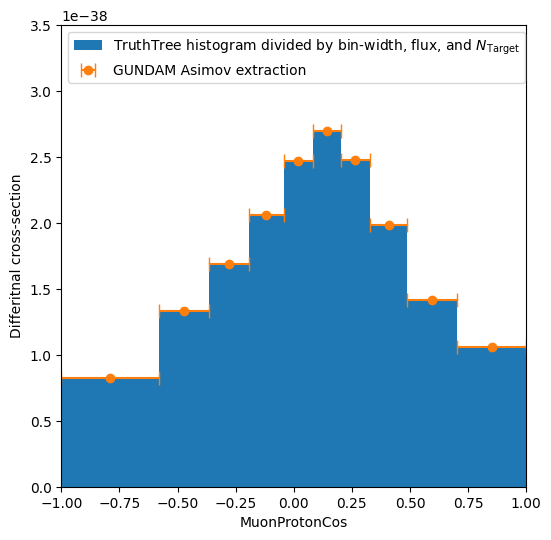

In [25]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(
    XsecBinning[:-1],
    bins=XsecBinning,
    weights=h_TruthTree/FluxIntegral/NTarget/XsecBinWidth,
    label=r'TruthTree histogram divided by bin-width, flux, and $N_{\text{Target}}$',
    # histtype='step',
)

ax.errorbar(
    XsecBinCenter, 
    h_CalcXsec,
    xerr=XsecBinWidth/2., 
    fmt='o', 
    capsize=5,
    label='GUNDAM Asimov extraction',
)

y_max = np.max(h_CalcXsec)

ax.set_ylim(0., 1.3*y_max)

ax.set_xlabel(VariableName)
ax.set_ylabel('Differitnal cross-section')

ax.set_xlim(XsecBinning[0], XsecBinning[-1])

ax.legend(loc='upper left')

fig.savefig(f'{WD}/plot.pdf', bbox_inches='tight')